In [12]:
# Requisito: OpenCV

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statistics
from scipy.ndimage import interpolation as inter

# imagens com ruído, a serem processadas
NOISY_FOLDER = 'noisy_data'

# imagens resultantes, após processamento
CLEAN_FOLDER = 'clean_data'

%matplotlib inline

In [6]:
# função para plotar duas imagens, original e modificada, lado-a-lado
def plot(img, mod):
    rcParams['figure.figsize'] = 20, 20
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(img, 'gray')
    axarr[1].imshow(mod, 'gray')

In [13]:
# imagem exemplo para mostrar as transformações passo-a-passo
img = cv2.imread(os.path.join(NOISY_FOLDER, '2.png'), 0)

In [3]:
# Função para binarização da imagem
# Ideia: calculamos o background da imagem usando um filtro de mediana, e em seguida,
# setamos os pixels da imagem original que são significativamente mais escuros do que o 
# background (o texto tende a ser mais escuro do que o ruído) em 0, os demais ficam brancos

def binarization(img, k_size=11, delta=30):
    background = cv2.medianBlur(img, k_size)
    mask = img > background - delta
    mask = mask.astype(np.uint8)
    return mask * WHITE_VALUE

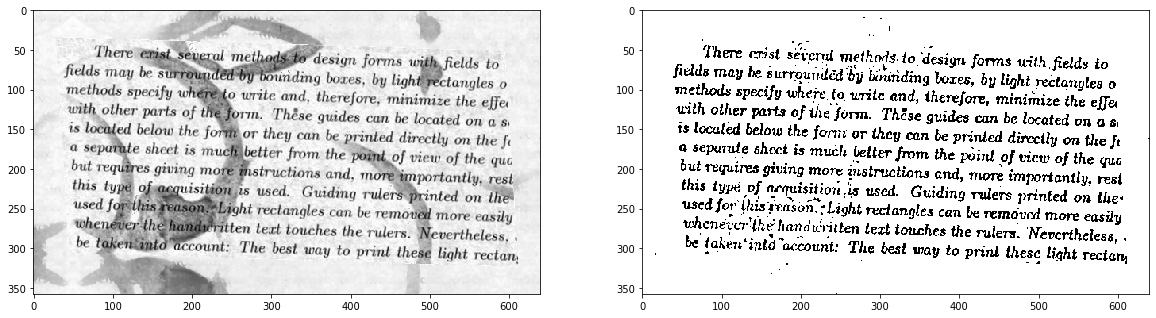

In [15]:
# exemplo de como ficou a imagem após ser binarizada
bin = binarization(img)
plot(img, bin)

In [4]:
# Função para alinhar todas as linhas na horizontal
# Idea: testamos vários ângulos (todos pertencentes a range(start, stop, step)), para ver qual 
# rotação parece deixar o texto na horizontal
# Como saber se uma imagem com texto está na horizontal? 
# Uma das formas é, para cada linha, calculamos o somatório de seus pixels. É de se esperar que,
# se o texto está na horizontal, estão teremos várias linhas com soma alta (praticamente
# completa de pixels brancos) alternadas com várias linhas com soma baixa (muitas letras, cor
# preta). Assim a soma dos deltas das somas das linhas será alta
# Conforme a orientação do texto vai se distanciando da horizontal, a intensidade da projeção do t
# texto sobre o eixo vertical vai ficando mais uniforme. Consequentemente, a soma dos deltas das 
# somas das linhas será menor

def horizontal_alignment(img, start=-20, stop=20, step=1):
    
    # função que calcula a soma dos deltas das somas das linhas (elevados ao quadrado, a fim de
    # que não se anulem), para a imagem rotacionada por um determinado ângulo
    def get_score(img, angle):
        data = inter.rotate(img, angle)
        histogram = np.sum(data, axis=1)
        delta = histogram[1:] - histogram[:-1]
        return np.sum(delta ** 2)
    
    # iteramos sobre os ângulos, e vemos qual produz o maior valor (soma dos deltas das somas 
    # das linhas ao quadrado)
    angles = np.arange(start, stop, step)
    scores = np.array([get_score(img, angle) for angle in angles])
    best_angle = angles[np.argmax(scores)]

    # achado um ângulo certo para rotacionar, fazemos uma rotação em torno do centro da imagem
    h, w = img.shape
    center = w // 2, h // 2
    matrix = cv2.getRotationMatrix2D(center, best_angle, 1)
    rotated = cv2.warpAffine(img, matrix, (w, h), flags=cv2.INTER_CUBIC, borderValue=WHITE_VALUE)
    return rotated

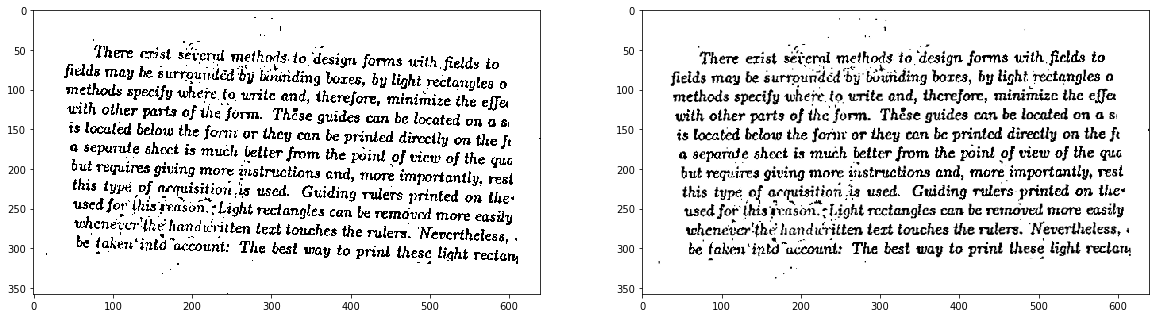

In [17]:
# exemplo de como ficou a imagem após ser rotacionada para que o texto ficasse na horizontal
rot = horizontal_alignment(bin)
plot(bin, rot)

In [18]:
# Percebemos que, embora as linhas estejam na horizontal, a disposição delas está na diagonal.
# Isso acontece porque, ao repararmos bem, muitas das imagens do dataset apresentam os parágrafos
# no formato de paralelogramos, ao invés de retângulos
# Embora visualmente a imagem não fique tão natural, isso não é problema para um OCR

In [11]:
# função para centralizar o parágrafo no meio da imagem
# A ideia é simples: calcular o centro de massa do texto e transladar a imagem de forma que esse
# centro de massa fique no centro da imagem
# O cálculo do centro de massa basicamente consiste em somar todas as posições dos pixels ligados
# (a imagem está binarizada) e dividir pela quantidade dos mesmos. Isso para cada orientação, 
# X e Y
# Usamos a função "moments" do "OpenCV" para facilitar o cálculo
def center(img):
    img = ~img
    moments = cv2.moments(img)
    col = moments['m10'] / moments['m00']
    row = moments['m01'] / moments['m00']
    nrows, ncols = img.shape
    drows = nrows // 2 - row
    dcols = ncols // 2 - col
    matrix = np.array([ [1, 0, dcols],
                        [0, 1, drows] ])
    return ~cv2.warpAffine(img, matrix, (ncols, nrows))

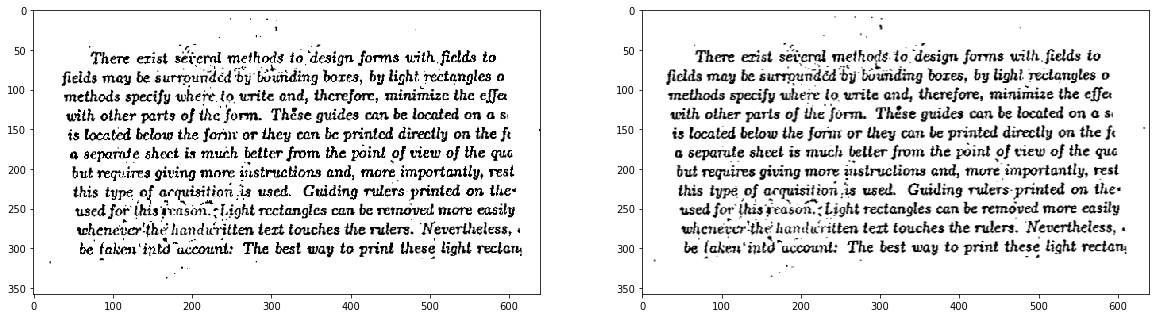

In [19]:
# exemplo de uso da função de centralização
cen = center(rot)
plot(rot, cen)

In [21]:
# salvando as imagens processadas no diretório clean_data
for _, _, files in os.walk(IMG_FOLDER):
    for file in files:
        img = cv2.imread(os.path.join(NOISY_FOLDER, file), 0)
        bin_img = binarization(img)
        rot_img = horizontal_alignment(bin_img)
        center_img = center(rot_img)
        cv2.imwrite(os.path.join(CLEAN_FOLDER, file), center_img)

In [24]:
# Ideias adicionais
# Estou em fim de período no Mestrado, com atividades acumuladas, e por isso não tive tempo de 
# alinhar as linhas do texto verticalmente, nem fazer a conversão de fonte itálica para normal
# (pelo menos não que tenha funcionado).
# De qualquer forma vou citar as ideias. 

# Primeiramente, para alinhar as linhas verticalmente:
#     1- Podemos reaproveitar os vetor de soma acumulada de pixels em cada linha, que usamos para 
#     rotacionar as imagens. As linhas de pixels que passam pelo texto terão somas de valores mais
#     baixos. 
#     2- Poderemos então por tentativa-e-erro ou por OTSU, determinar um threshold que nos permita
#     dizer que, abaixo dele, com certeza uma linha de pixels passa pelo texto.
#     3- Isso vai formar blocos de linhas de pixels que temos certeza que pertencem a linhas do 
#     texto, alternados com blocos que provavelmente não estão. 
#     4- Por garantia, para pegar as linhas de pixel que contêm acentos ou partes altas de letras,
#     e também as que contèm partes baixas, adicionamos algum número de linhas de pixels (5, por 
#     exemplo) que estejam na borda dos blocos de certeza
#     5- Por fim, para cada bloco de certeza, calculamos seu centro de massa na direção horizontal 
#     e o transladamos de forma que esse centro de massa fique no meio da linha correspondente

# Para remover o itálico do texto:
#     1- Poderíamos reaproveitar os blocos de certeza (correspondem a uma linha do texto) sem 
#     contar as margens de segurança, e processá-los individualmente.
#     2- Cada processamento consiste em calcular o centro de massa de cada linha de pixel, e por 
#     regressão linear, determinar a reta que mais se ajusta a esses centros
#     3- A inclinação da reta vai nos dizer a inclinação das letras na linha (ou seja, do 
#     itálico)
#     4- Aí calculamos o deslocamento que cada linha deve sofrer, em relação à linha do meio do 
#     bloco, que vai permanecer fixa
#     5- Finalmente transladamos cada linha de pixels individualmente (inclusive com as margens
#     de segurança)